# Query Data and Plot Together

In this notebook we will explain how to query well, horizon, and seismic data.

We will explain how to extract seismic data around the wellbore using `real-simple-seismic`. Same is doable with
`OpenVDS` files as well using the `get_minicube` convenience function. Since `OpenVDS` has bricked indexing as well
it will bring chunks of data much faster than `real-simple-seismic`. If you are using a deep neural network
we recommend you stick to `OpenVDS`, if not `real-simple-seismic` easier to use.

Finally, we will show nice plots that show all data together!

Let's start by importing some of the tools we need.

In [1]:
from math import floor, ceil
from os.path import join

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json

# Loading AWS Credentials
<span style="color:red">**THIS ONLY APPLIES TO ON-PREM (LOCAL) ACCESS TO S3 DATA. IF YOU ARE ON SAGEMAKER DON'T DO THIS.**

AWS credentials must be stored in environment variables.

To access competition data on-premise, you will need these environment variables set. They expire occasionally, so please update your variables when you get permission errors. See instructions PDF on how to obtain them.

Variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, and `AWS_SESSION_TOKEN`

If these are not set, you will get a "Forbidden" error. Configuring this depends on your operating system. It needs to be set in your global environment or within your virtual environment **before** launching Jupyter server or scripts. It is usually set using terminal. AWS SSO logins provides a convenient way to copy these for your account into your terminal or command-prompt. It will look something like this:


| **Linux / UNIX / MacOS**                                | **Windows**                                        |
|:--------------------------------------------------------|---------------------------------------------------:|
| `export AWS_ACCESS_KEY_ID="your_access_key"`            | `SET AWS_ACCESS_KEY_ID=your_access_key`            |
| `export AWS_SECRET_ACCESS_KEY="your_secret_access_key"` | `SET AWS_SECRET_ACCESS_KEY=your_secret_access_key` |
| `export AWS_SESSION_TOKEN="your_long_session_token"`    | `SET AWS_SESSION_TOKEN=your_long_session_token`    |

After credentials are set, we can read data from the S3 buckets just like we are on SageMaker environment.

Reading the wells from S3.

In [2]:
%%time
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_training_wells.json.gz'

well_df = read_json(
    path_or_buf=join(well_bucket, well_file),
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)

well_df

CPU times: user 148 ms, sys: 27.8 ms, total: 176 ms
Wall time: 222 ms


tvdss     inline      xline    gamma   rshal    rdeep  \
well_id twt                                                                 
well_01 1136.5  2798.4675  2992.8834  2202.6259   8.6726  3.7827   2.2789   
        1137.0  2798.4723  2992.8834  2202.6259   8.6323  3.7982   2.2860   
        1137.5  2798.4771  2992.8834  2202.6258   8.5921  3.8136   2.2931   
        1138.0  2798.4819  2992.8834  2202.6258   8.5518  3.8290   2.3002   
        1138.5  2798.4867  2992.8834  2202.6258   8.5115  3.8445   2.3073   
...                   ...        ...        ...      ...     ...      ...   
well_33 3275.5  4930.9019  3184.5065  2347.5496  25.9762     NaN   1.2904   
        3276.0  4931.7274  3184.5094  2347.5584  32.2211     NaN   0.3794   
        3276.5  4932.5529  3184.5122  2347.5671  24.3830     NaN   0.6208   
        3277.0  4933.3784  3184.5150  2347.5758  32.3072     NaN   7.0806   
        3277.5  4934.2090  3184.5178  2347.5846  44.1339     NaN  17.5096   

                  nphi     cal    rhob      dtc       dts  
well_id twt                                                
well_01 1136.5     NaN     NaN     NaN  58.3867       NaN  
        1137.0     NaN     NaN     NaN  58.4215       NaN  
        1137.5     NaN     NaN     NaN  58.4564       NaN  
        1138.0     NaN     NaN     NaN  58.4912       NaN  
        1138.5     NaN     NaN     NaN  58.5260       NaN  
...                ...     ...     ...      ...       ...  
well_33 3275.5  3.9099  5.8378  2.5694  67.4372  104.0350  
        3276.0  3.5481  5.8382  2.5828  72.2925  109.3575  
        3276.5  2.5321  5.8363  2.4341  68.8159  104.5286  
        3277.0  3.0198  5.8567  2.3997  71.4051  105.4713  
        3277.5  5.1812  5.8652  2.4335      NaN       NaN  

[14824 rows x 11 columns]

Get well names and separate `DataFrame` per well, and put in a dictionary.

We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
query from the seismic data.

In [3]:
well_names = well_df.index.levels[0].to_list()
num_wells = len(well_names)

wells = {}
il_ranges = {}
xl_ranges = {}
for well_name in well_names:
    well = well_df.loc[well_name]
    well_ils_xls = well[['inline', 'xline']]
    il_xl_min = well_ils_xls.min()
    il_xl_max = well_ils_xls.max()

    wells[well_name] = well
    il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
    xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])

Pretty print well names and il/xl ranges

In [4]:
for well in wells.keys():
    print(f"{well}:\tIL Range: {il_ranges[well]}\t\tXL Range: {xl_ranges[well]}")

well_01:	IL Range: (2992, 2994)		XL Range: (2202, 2210)
well_11:	IL Range: (3523, 3524)		XL Range: (2397, 2401)
well_21:	IL Range: (2765, 2770)		XL Range: (1490, 1493)
well_25:	IL Range: (1193, 1196)		XL Range: (2512, 2518)
well_27:	IL Range: (2856, 2859)		XL Range: (2285, 2291)
well_33:	IL Range: (3179, 3185)		XL Range: (2337, 2348)


Now, we need to extract seismic values around the wellbore. Let's start with
mounting `real-simple-seismic` volumes of interest so we can query later.

**Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**

**Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**

In [5]:
seismic_bucket = r's3://sagemaker-gitc2021/poseidon/seismic/rss/'

seismic_files = [
    'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
    'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
    'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
#     'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
]

# We loop through all files, and make connections to all four.
# This takes about a minute.
# The handles are later used for querying.
rss_handles = []
for seismic_file in seismic_files:
    current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

    rss_handles.append(current_rss)

Connection complete.


Now we can query only the traces around the well (makes a miniature 3d cube, which is usually called a minicube).

We do this for each well and for every cube.

The dimensions of the minicubes are:
1. inlines
2. crosslines
3. z_values

So if you want to slice the first crossline from the minicube you would do `cube_data[:, 0, :]` or if you want to
look at the 3rd inline, you would do `cube_data[2, :, :]`

In [6]:
from itertools import product
import numpy as np

# let's have nicer names for seismic data
# seismic_names = ('near', 'mid', 'far', 'velocity')
seismic_names = ('near', 'mid', 'far')


well_seismic = {}
for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]

    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

    # Use product to have all il/xl pairs within our ranges
    ilxl_pairs = list(product(ils, xls))

    cube_data = {}
    # In rss, for minicube extraction we query trace by trace.
    for rss_handle, seismic_name in zip(rss_handles, seismic_names):
        tmp = []
        for trace_ilxl in ilxl_pairs:
            tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

        # Traces aren't in a "cube" shape, they come sequential. So we reshape!
        cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

    well_seismic[well] = cube_data

Now we have all the traces around the well. Next, lets load up the horizons so we can display all of them together.

In [7]:
%%capture

horizon_bucket = 's3://sagemaker-gitc2021/poseidon/horizons/'
horizon_files = ['water_bottom', 'top_heywood', 'top_johnson', 'top_jameison', 'top_near_plover']

horizons = []
for horizon in horizon_files:
    horizons.append(
        read_csv(filepath_or_buffer=horizon_bucket + f'{horizon}.csv.gz',
                 index_col=[0, 1],
                 compression='gzip'))

horizons = concat(horizons, axis=1)

In [8]:
horizons

water_bottom  top_heywood  top_johnson  top_jameison  \
inline xline                                                         
1080   1080          581.9       2058.3       2346.8        2719.2   
       1081          581.8       2058.3       2346.8        2719.3   
       1082          581.8       2058.4       2347.1        2719.5   
       1083          581.8       2058.4       2347.3        2719.7   
       1084          581.8       2058.4       2347.6        2720.0   
...                    ...          ...          ...           ...   
3700   3196          648.1       2062.7       2493.0        2633.7   
       3197          648.2       2062.7       2493.0        2633.7   
       3198          648.2       2062.7       2492.9        2633.6   
       3199          648.2       2062.7       2492.9        2633.6   
       3200          648.2       2062.7       2492.9        2633.6   

              top_near_plover  
inline xline                   
1080   1080            3327.9  
       1081            3327.8  
       1082            3327.8  
       1083            3327.8  
       1084            3327.7  
...                       ...  
3700   3196            3985.7  
       3197            3985.1  
       3198            3984.5  
       3199            3983.9  
       3200            3983.3  

[5559141 rows x 5 columns]

Now that we loaded all the horizons, wells, and seismic minicubes, let's plot all of them together.

*Note some of the missing logs. To augment or not to augment.*

### Some key comments
1. We have different ranges for seismic vs. velocity (vmin/vmax).
2. We filter the horizon `DataFrame` in the minicube range using a `pd.IndexSlice` instance,
which is a convenient way to slice a `DataFrame`.
3. We are showing the **center** inline and all crosslines for the wellbore.
4. Deviations look exaggerated because of the small lateral scale.
5. We can now extract seismic traces **along** the wellbores (linear interpolator.
or nearest neighbor interpolation + averaging).
6. Typical regression models will map from seismic -> well data using values extracted at seismic(s).
7. A CNN (deep neural network) based approach would use larger cubes around well log points for convolutions.
8. Sorry, for some repetition in the code for labeling etc!

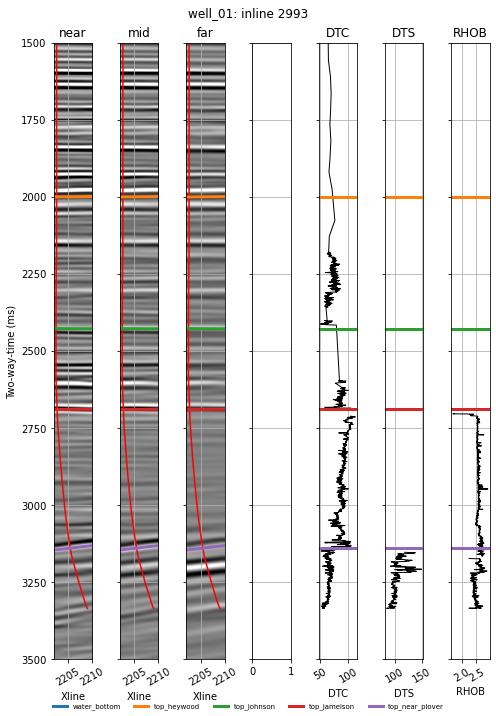

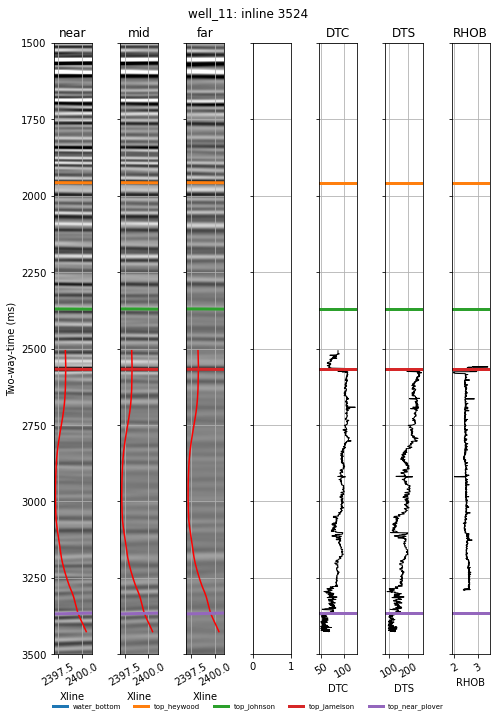

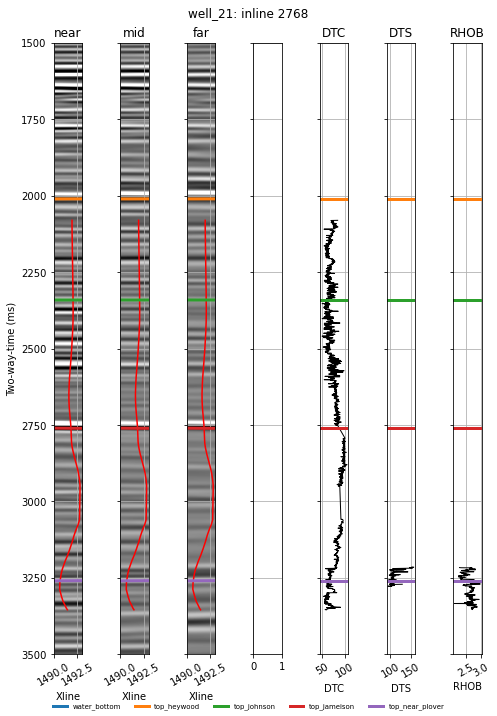

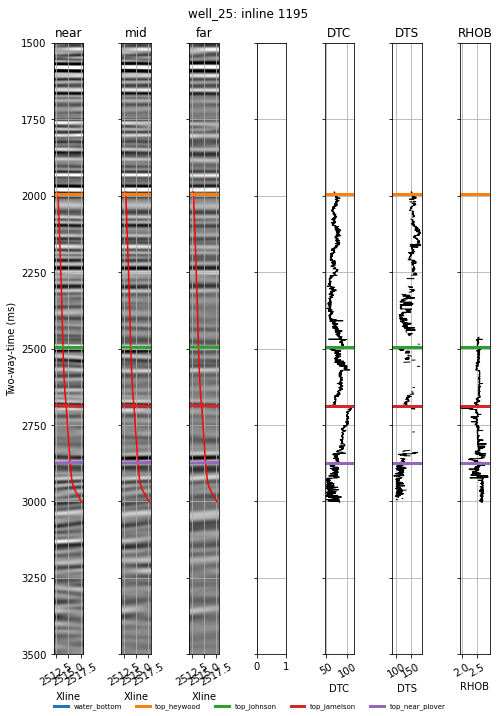

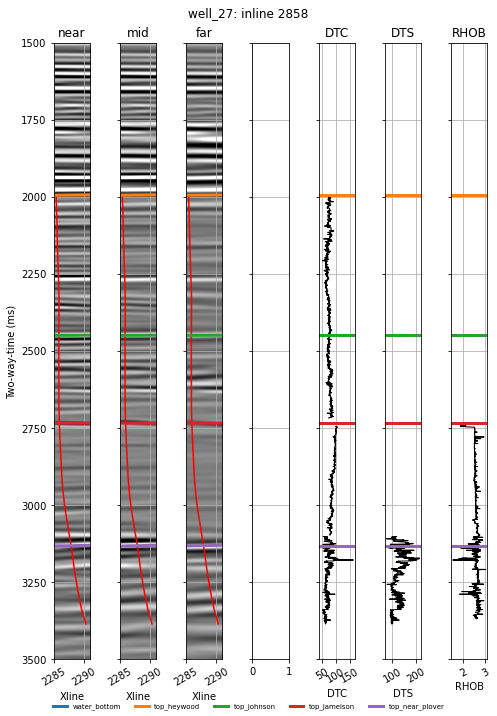

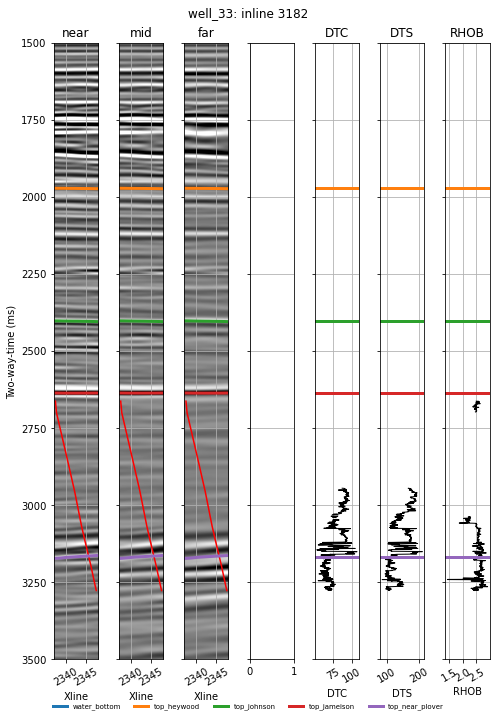

In [9]:
import matplotlib.pyplot as plt

colors = ['gray_r']*3 + ['plasma']
vmins = [-39000]*3 + [1500]
vmaxs = [39000]*3 + [5500]

for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]
    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # inline increment is 1

    # We just want to plot the "center" inline and all crosslines
    num_il = il_max - il_min + 1
    plot_il_idx = num_il // 2

    fig, axes = plt.subplots(1, 7, sharey='all', figsize=(7, 10))

    # Let's filter horizon to the il/xl range we need

    minicube_horizons = horizons.loc[IndexSlice[il_min:il_max, xl_min:xl_max], :]

    for idx, (axis, seismic_name) in enumerate(zip(axes[:6], seismic_names)):
        seismic = well_seismic[well][seismic_name]
        # mean, std = np.nanmean(seismic), np.nanstd(seismic)
        axis.imshow(seismic[plot_il_idx, :, :].T, aspect='auto',
                    extent=[xl_min, xl_max, 6000, 0], interpolation='bicubic',
                    vmin=vmins[idx], vmax=vmaxs[idx], cmap=colors[idx])

        axis.set_xlabel('Xline')
        axis.plot(wells[well]['xline'], wells[well].index.values, 'r')
        axis.set_title(seismic_name)
        axis.tick_params(axis='x', rotation=30)
        hrz_lines = axis.plot(minicube_horizons.loc[ils[plot_il_idx]], lw=3)

    axes[4].plot(wells[well]['dtc'], wells[well].index.values, 'k', lw=1)
    axes[4].set_title('DTC'), axes[4].set_xlabel('DTC')
    axes[5].plot(wells[well]['dts'], wells[well].index.values, 'k', lw=1)
    axes[5].set_title('DTS'), axes[5].set_xlabel('DTS')
    axes[6].plot(wells[well]['rhob'], wells[well].index.values, 'k', lw=1)
    axes[6].set_title('RHOB'), axes[6].set_xlabel('RHOB')

    hrz_colors = [hrz_line.get_color() for hrz_line in hrz_lines]
    hrz_labels = horizons.keys()
    for idx, value in enumerate(minicube_horizons.loc[ils[plot_il_idx], round(np.mean(xls))].values):
        axes[4].axhline(value, lw=3, color=hrz_colors[idx])
        axes[4].tick_params(axis='x', rotation=30)
        axes[5].axhline(value, lw=3, color=hrz_colors[idx])
        axes[5].tick_params(axis='x', rotation=30)
        axes[6].axhline(value, lw=3, color=hrz_colors[idx], label=hrz_labels[idx])
        axes[6].tick_params(axis='x', rotation=30)

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(hrz_labels),
               fontsize='x-small', markerscale=0.1, frameon=False)

    axes[0].set_ylabel('Two-way-time (ms)')
    axes[0].set_ylim([3500, 1500])
    fig.suptitle(well + f': inline {ils[plot_il_idx]}')
    fig.tight_layout()

    for axis in axes:
        axis.grid('minor')

Now we can move on to the next notebook where we will show to make `X_train` and `y_train` datasets for 1 well.